In [118]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACE_API_KEY"] = os.getenv("HUGGINGFACE_API_KEY")

In [119]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="qwen/qwen3-32b")

### To set a command from one agent to another agent

In [120]:
from langgraph.types import Command

### We have a inbuilt ReactAgent from langgraph 

In [121]:
from langgraph.prebuilt import create_react_agent

### Using this command itself we can switch to multiple agents
    - goto : Where to switch to next agent
    - update : What to update in the state


In [122]:
def add_number(state):
    result =state["num1"] + state["num2"]
    return Command(goto="multiply", update={"sum":result})

In [123]:
state = {"num1":10, "num2":20}

In [124]:
add_number(state)

Command(update={'sum': 30}, goto='multiply')

### Creating one dummy MultiAgent

In [125]:
from langchain_core.tools import tool
@tool
def transfer_to_multiplication():
    """Ask multiplication agent for help"""
    return 

In [126]:
@tool
def transfer_to_addition():
    """Ask addition agent for help"""
    return 

In [127]:
llm_with_tools = llm.bind_tools([transfer_to_addition, transfer_to_multiplication])

In [128]:
response = llm_with_tools.invoke("Hi")

In [129]:
response.content

'Hello! How can I assist you today?'

In [130]:
response.tool_calls

[]

In [131]:
response = llm_with_tools.invoke("what is 2*6")

In [132]:
response.content

''

In [133]:
response.tool_calls

[{'name': 'transfer_to_multiplication',
  'args': {},
  'id': 'ymd0atj34',
  'type': 'tool_call'}]

# This is a Network Agent or Collaborative Agent

In [134]:
from typing_extensions import Literal
from langgraph.graph import MessagesState, StateGraph, START, END

# AGENT 1

In [135]:
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_agent", "__end__"]]:
    """returns:
            - multiplication_agent: if the user asks for multiplication
            - __end__: if the user asks for addition
    """

    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
    ai_msg = llm.bind_tools([transfer_to_multiplication]).invoke(messages)
    
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred to multiplication agent",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_agent", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

# AGENT 2

In [136]:
##Agent2
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_agent", "__end__"]]:
    """
    returns:
        - additional_agent: if the user asks for addition
        - __end__: if the user asks for mutiplication
    """
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = llm.bind_tools([transfer_to_addition]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred to addition agent",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_agent", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [137]:
graph=StateGraph(MessagesState)
graph.add_node("additional_agent",additional_expert)
graph.add_node("multiplication_agent",multiplication_expert)
graph.add_edge(START, "additional_agent")
app=graph.compile()

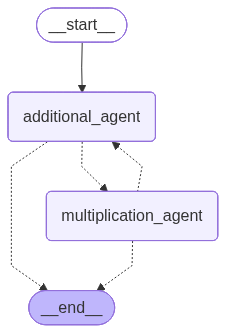

In [138]:
app

### 1. Scenario: `8 * 5` (Direct Calculation)
*   **Where are we?** We are at the **Multiplication Agent**.
*   **System Prompt:** "You are a multiplication expert."
*   **What happens:**
    1.  The LLM looks at `8 * 5`.
    2.  It thinks: *"I am the multiplication expert. I can do this myself."*
    3.  **The LLM calculates `40` directly** (just like you or I would do in our heads).
    4.  **Result:** It replies "40". It does **not** call any tool.

### 2. Scenario: `4 + 6` (Transfer -> Calculation)
*   **Where are we?** Imagine we start at the **Multiplication Agent**.
*   **System Prompt:** "You are a multiplication expert. Ask addition expert for help with addition."
*   **What happens:**
    1.  The LLM looks at `4 + 6`.
    2.  It thinks: *"This is addition. That's not my job. I need to transfer this."*
    3.  **Tool Call:** It calls `transfer_to_addition_expert`. **This is just a dummy switch.** It does zero math.
    4.  **The Switch:** The code moves the conversation to the **Addition Agent**.
    5.  **Now at Addition Agent:** The same LLM puts on the "Addition Expert" hat.
    6.  It thinks: *"I am the addition expert. `4 + 6`? Easy."*
    7.  **The LLM calculates `10` directly** in its head.
    8.  **Result:** It replies "10".

### Summary
*   **The Tools:** Are just **Routing Switches** (like a traffic light: "Go there"). They contain **no math logic**.
*   **The Agents:** Are just the **Same LLM** wearing different "nametags" (System Prompts).
*   **The Math:** Is done purely by the LLM's internal training.

In [139]:
inputs = {"messages": [("user", "what's (3*4) + (4 + 6) * (5 * 3). Provide me the output")]}

print(f"🚀 Starting with input: {inputs['messages'][0][1]}\n")

for output in app.stream(inputs, stream_mode="updates"):
    for node_name, update in output.items():
        print(f"📍 Visiting: {node_name}")
        
        for msg in update.get("messages", []):
            # Handle Dict messages
            if isinstance(msg, dict):
                content = msg.get("content", "")
                role = msg.get("role", "")
                tool_calls = msg.get("tool_calls", [])
                
                if role == "tool":
                    print(f"   🔧  Tool Output: \"{content}\"\n")
                elif role == "assistant":
                    if content:
                        print(f"   🤔  Agent Thought: \"{content}\"")
                    if tool_calls:
                        print(f"   🛠️  Agent decided to call tool: {tool_calls[0]['name']}")
                        print(f"   🔄  Transferring task...\n")
                    else:
                        print(f"   💡  Agent produced a final answer:")
                        print(f"   📝  \"{content}\"\n")
            
            # Handle Object messages (AIMessage, etc.)
            elif hasattr(msg, 'content'):
                content = msg.content
                tool_calls = getattr(msg, 'tool_calls', [])
                msg_type = getattr(msg, 'type', '')
                
                if tool_calls:
                    if content:
                        print(f"   🤔  Agent Thought: \"{content}\"")
                    print(f"   🛠️  Agent decided to call tool: {tool_calls[0]['name']}")
                    print(f"   🔄  Transferring task...\n")
                elif msg_type == 'ai':
                    print(f"   💡  Agent produced a final answer:")
                    print(f"   📝  \"{content}\"\n")
                elif msg_type == 'tool':
                    print(f"   🔧  Tool Output: \"{content}\"\n")

print("✅ Execution Complete")

🚀 Starting with input: what's (3*4) + (4 + 6) * (5 * 3). Provide me the output

📍 Visiting: additional_agent
   🛠️  Agent decided to call tool: transfer_to_multiplication
   🔄  Transferring task...

   🔧  Tool Output: "Successfully transferred to multiplication agent"

📍 Visiting: multiplication_agent
   🛠️  Agent decided to call tool: transfer_to_addition
   🔄  Transferring task...

   🔧  Tool Output: "Successfully transferred to addition agent"

📍 Visiting: additional_agent
   💡  Agent produced a final answer:
   📝  "The final result of the calculation is **162**. 

Here's the breakdown:
1. **First part**: $3 \times 4 = 12$
2. **Second part**: $(4 + 6) \times (5 \times 3) = 10 \times 15 = 150$
3. **Total**: $12 + 150 = 162$"

✅ Execution Complete


# Creating a Real Agent with the Real Time tool

In [140]:
from langchain_community.tools import DuckDuckGoSearchRun

In [141]:
search = DuckDuckGoSearchRun()

### This is just a function not a tool

In [142]:
from langchain_experimental.utilities import PythonREPL

### It is used to run the Python code which is in string format

In [143]:
repl = PythonREPL()

In [144]:
code = """
x = 5
s = x * 4
print(s)
"""

In [145]:
repl.run(code)

'20\n'

In [146]:
from typing import Annotated

In [147]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n python\n{code}\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [148]:
python_repl_tool

StructuredTool(name='python_repl_tool', description='Use this to execute python code. If you want to see the output of a value,\n    you should print it out with `print(...)`. This is visible to the user.', args_schema=<class 'langchain_core.utils.pydantic.python_repl_tool'>, func=<function python_repl_tool at 0x0000023C38368180>)

In [150]:
print(python_repl_tool.invoke(code))

Successfully executed:
 python

x = 5
s = x * 4
print(s)

Stdout: 20


If you have completed all tasks, respond with FINAL ANSWER.


In [158]:
from langgraph.graph import MessagesState, START, END, StateGraph
from typing import Literal

In [159]:
#Agent 1
def research_node(state: MessagesState) -> Command[Literal["chart_generator", END]]:
    """
    This node is used to research the problem.
    """
    pass

In [160]:
#Agent 2
def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    """
    This node is used to generate the chart.
    """
    pass

In [163]:
workflow = StateGraph(MessagesState)

In [164]:
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_edge(START, "researcher")


In [ ]:
app = workflow.compile()

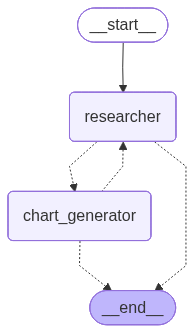

In [167]:
app